## Defining configuration

Install lime for explanations

In [ ]:
import os
import tarfile
from google.colab import drive

drive_path = ('drive')
drive.mount(os.path.join(os.getcwd(), drive_path))
tar = tarfile.open('/content/drive/My Drive/Colab Notebooks/datasets/ChestX-ray8.tar', 'r')
tar.extractall(os.path.join(os.getcwd(), 'data'))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git data/covid-chestxray-dataset

Cloning into 'data/covid-chestxray-dataset'...
remote: Enumerating objects: 3213, done.
remote: Total 3213 (delta 0), reused 0 (delta 0), pack-reused 3213
Receiving objects: 100% (3213/3213), 582.57 MiB | 36.49 MiB/s, done.
Resolving deltas: 100% (1276/1276), done.
Checking out files: 100% (991/991), done.


In [ ]:
config = {
  'PATHS': {
    'RAW_DATA': os.path.join(os.getcwd(), 'data'),
    'COVID_CHEST_XRAY_DATA': os.path.join(os.getcwd(), 'data', 'covid-chestxray-dataset'),
    'CHEST_XRAY_8_DATA': os.path.join(os.getcwd(), 'data', 'ChestX-ray8'),
    'PROCESSED_DATA': os.path.join(os.getcwd(), 'data', 'processed'),
    'TRAIN_SET': os.path.join(os.getcwd(), 'data', 'processed', 'train_set.csv'),
    'VAL_SET': os.path.join(os.getcwd(), 'data', 'processed', 'val_set.csv'),
    'TEST_SET': os.path.join(os.getcwd(), 'data', 'processed', 'test_set.csv'),
    'IMAGES': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'output', 'documents', 'generated_images'),
    'LOGS': os.path.join(os.getcwd(), 'results', 'logs'),
    'CHECKPOINTS': os.path.join(os.getcwd(), 'model', 'checkpoints'),
    'MODELS_FOLDER': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'model_covid'),
    'MODEL_WEIGHTS': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'model_covid', 'model_weights20200531-103213.index'),
    'MODEL_TO_LOAD': os.path.join(os.getcwd(), drive_path, 'My Drive', 'Colab Notebooks', 'models', 'model_covid', 'model20200705-174256.h5'),
    'OUTPUT_CLASS_INDICES': os.path.join(os.getcwd(), 'data', 'interpretability', 'output_class_indices.pkl'),
    'LIME_EXPLAINER': os.path.join(os.getcwd(), 'data', 'interpretability', 'lime_explainer.pkl'),
  },
  'DATA': {
    'IMG_DIM': 331,
    'VIEW': 'PA',
    'VAL_SPLIT_PERCENT': 0.08,
    'TEST_SPLIT_PERCENT': 0.1,
    'NUM_CHEST_XRAY_8_IMAGES': 1000,
    'CLASSES': [
      'NO FINDING',
      'COVID-19'
    ],
    'OTHER_CONTAINS_ONLY_HEALTHY': True,
    
    # One of {'class_weight', 'reduce'}
    'CLASS_BALANCE_STRATEGY': 'reduce'      
  },
  'TRAIN': {
    'BATCH_SIZE': 32,
    'EPOCHS': 150,
    'THRESHOLDS': 0.5,
    'ENABLE_EARLY_STOPPING': True,
    'PATIENCE_FOR_EARLY_STOPPING': 10,
    'NUM_GPUS': 0
  },
  'NN': {
    'NODES_DENSE0': 256,
    'LR': 0.000001,
    'OPTIMIZER': 'adam',
    'DROPOUT': 0.4,
    'L2_LAMBDA': 0.0001
  },
  'LIME': {
    'KERNEL_WIDTH': 4,
    'FEATURE_SELECTION': 'lasso_path',
    'NUM_FEATURES': 1000,
    'NUM_SAMPLES': 1000,
    'COVID_ONLY': False
  },
  'PREDICTION': {
    'THRESHOLD': 0.5
  }
}

## Preprocessing
### Importing dependencies

In [ ]:
from pathlib import Path
import re

for path in config['PATHS']:
  if not bool(re.match('^.*\.[a-zA-Z0-9]+$', config['PATHS'][path])):
    Path(config['PATHS'][path]).mkdir(parents=True, exist_ok=True)
  else:
    splitted_path = config['PATHS'][path][:config['PATHS'][path].rfind('/')]
    Path(splitted_path).mkdir(parents=True, exist_ok=True)

In [ ]:
import pandas as pd

covid_chest_xray_path = config['PATHS']['COVID_CHEST_XRAY_DATA']
chest_xray_8_path = config['PATHS']['CHEST_XRAY_8_DATA']

covid_chest_xray_df = pd.read_csv(os.path.join(covid_chest_xray_path, 'metadata.csv'))
covid_chest_xray_df['filename'] = [os.path.join(covid_chest_xray_path, 'images', row) for row in covid_chest_xray_df['filename'].astype(str)]

covid_views_cxrs_df = covid_chest_xray_df['view'].str.match(config['DATA']['VIEW'])
covid_pos_df = covid_chest_xray_df['finding'].str.match('COVID-19')
covid_df = covid_chest_xray_df[covid_pos_df & covid_views_cxrs_df] 

chest_xray_8_df = pd.read_csv(os.path.join(chest_xray_8_path, 'subset.csv'))
num_chest_xray_8_imgs = config['DATA']['NUM_CHEST_XRAY_8_IMAGES']
chest_xray_8_normal_df = chest_xray_8_df[chest_xray_8_df['Finding Labels'].str.match('No Finding')]
chest_xray_8_pneum_df = chest_xray_8_df[chest_xray_8_df['Finding Labels'].str.match('(?!No Finding)')]

chest_xray_8_normal_sample_df = chest_xray_8_normal_df.sample(frac = num_chest_xray_8_imgs / chest_xray_8_normal_df.shape[0], random_state=num_chest_xray_8_imgs)

chest_xray_8_pneum_sample_df = chest_xray_8_pneum_df.sample(frac = num_chest_xray_8_imgs / chest_xray_8_pneum_df.shape[0], random_state=num_chest_xray_8_imgs)

if config['DATA']['OTHER_CONTAINS_ONLY_HEALTHY']:
  chest_xray_8_df = chest_xray_8_normal_sample_df
else:
  chest_xray_8_df = pd.concat([chest_xray_8_normal_sample_df, chest_xray_8_pneum_sample_df], axis=0)

chest_xray_8_df['filename'] = [os.path.join(chest_xray_8_path, row) for row in chest_xray_8_df['Image Index'].astype(str)]

In [ ]:
covid_df['label'] = 'COVID-19'
chest_xray_8_df['label'] = 'NO FINDING'

chest_xray_8_selected_df = None
if config['DATA']['CLASS_BALANCE_STRATEGY'] == 'reduce':
  chest_xray_8_selected_df = chest_xray_8_df.head(covid_df.shape[0])
else:
  chest_xray_8_selected_df = chest_xray_8_df

file_df = pd.concat(
        [covid_df[['filename', 'label']],
        chest_xray_8_selected_df[['filename', 'label']]], axis=0)         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
from sklearn.model_selection import train_test_split

validation_split_size = config['DATA']['VAL_SPLIT_PERCENT']
test_split_size = config['DATA']['TEST_SPLIT_PERCENT']
file_df_train, file_df_test = train_test_split(file_df, test_size=test_split_size, stratify=file_df['label'], random_state=42)
relative_validation_split_size = validation_split_size / (1 - test_split_size)
file_df_train, file_df_val = train_test_split(file_df_train, test_size=relative_validation_split_size,
                                                    stratify=file_df_train['label'], random_state=42)

if not os.path.exists(config['PATHS']['PROCESSED_DATA']):
    os.makedirs(config['PATHS']['PROCESSED_DATA'])
file_df_train.to_csv(config['PATHS']['TRAIN_SET'])
file_df_val.to_csv(config['PATHS']['VAL_SET'])
file_df_test.to_csv(config['PATHS']['TEST_SET'])

In [ ]:
import datetime
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(config['PATHS']['LOGS'], 'training', cur_date)
model_filename = 'weights.{epoch:02d}-{auc:.2f}.hdf5'
checkpoint_path = os.path.join(config['PATHS']['CHECKPOINTS'], model_filename)
print(checkpoint_path)
if not os.path.exists(os.path.join(config['PATHS']['LOGS'], 'training')):
    os.makedirs(os.path.join(config['PATHS']['LOGS'], 'training'))
    
data = {}
data['TRAIN'] = pd.read_csv(config['PATHS']['TRAIN_SET'])
data['VAL'] = pd.read_csv(config['PATHS']['VAL_SET'])
data['TEST'] = pd.read_csv(config['PATHS']['TEST_SET'])

callbacks = []
if config['TRAIN']['ENABLE_EARLY_STOPPING']:
  early_stopping = EarlyStopping(
    monitor='auc',
    verbose=1, 
    patience=config['TRAIN']['PATIENCE_FOR_EARLY_STOPPING'], 
    mode='max', 
    restore_best_weights=False)
  callbacks.append(early_stopping)
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks.append(tensorboard)
model_checkpoint = ModelCheckpoint(model_filename, 
                                   monitor='auc', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True, 
                                   mode='max', 
                                   save_freq='epoch'
)
callbacks.append(model_checkpoint)

/content/model/checkpoints/weights.{epoch:02d}-{auc:.2f}.hdf5


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import dill

train_img_gen = ImageDataGenerator(rotation_range=10, samplewise_std_normalization=True, samplewise_center=True)
val_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)
test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

img_shape = (config['DATA']['IMG_DIM'], config['DATA']['IMG_DIM'])

class_mode = 'categorical'
train_generator = train_img_gen.flow_from_dataframe(
    dataframe=data['TRAIN'],
    x_col="filename",
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True)
val_generator = val_img_gen.flow_from_dataframe(
    dataframe=data['VAL'],
    x_col="filename",
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True)
test_generator = test_img_gen.flow_from_dataframe(
    dataframe=data['TEST'],
    x_col="filename",
    y_col='label',
    target_size=img_shape,
    batch_size=config['TRAIN']['BATCH_SIZE'],
    class_mode=class_mode,
    validate_filenames=True,
    shuffle=False)

dill.dump(test_generator.class_indices, open(config['PATHS']['OUTPUT_CLASS_INDICES'], 'wb+'))

histogram = np.bincount(np.array(train_generator.labels).astype(int))

class_weight = None
if config['DATA']['CLASS_BALANCE_STRATEGY'] == 'class_weight':
  class_multiplier_list = [min(histogram) / max(histogram)]
  class_multiplier_list.insert(int(histogram[0] > histogram[1]), 1.0)

  class_multiplier = [
          class_multiplier_list[config['DATA']['CLASSES'].index(c)]
              for c in test_generator.class_indices
  ]

  weights = [(1.0 / len(histogram)) * sum(histogram) / histogram[i] for i in range(len(histogram))]

  class_weight = {i: class_multiplier[i] for i in range(len(histogram))}  

Found 347 validated image filenames belonging to 2 classes.
Found 34 validated image filenames belonging to 2 classes.
Found 43 validated image filenames belonging to 2 classes.


In [ ]:
!rm -R /content/results

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, Activation, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import Constant
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.utils import multi_gpu_model

covid_class_idx = test_generator.class_indices['COVID-19']   
thresholds = 1.0 / len(config['DATA']['CLASSES'])
metrics = ['accuracy', CategoricalAccuracy(name='c_accuracy'),
    Precision(name='precision', thresholds=thresholds, class_id=covid_class_idx),
    Recall(name='recall', thresholds=thresholds, class_id=covid_class_idx),
    AUC(name='auc'),
    F1Score(name='f1score', threshold=thresholds, num_classes=len(config['DATA']['CLASSES']))]

input_shape = (config['DATA']['IMG_DIM'], config['DATA']['IMG_DIM'], 3)
num_gpus = config['TRAIN']['NUM_GPUS']

model_config = config['NN']

nodes_dense0 = model_config['NODES_DENSE0']
lr = model_config['LR']
dropout = model_config['DROPOUT']
l2_lambda = model_config['L2_LAMBDA']

if model_config['OPTIMIZER'] == 'sgd':
    optimizer = SGD(learning_rate=lr)
else:
    optimizer = Adam(learning_rate=lr)

histogram = np.bincount([config['DATA']['CLASSES'].index(label) for label in data['TRAIN']['label'].astype(str)])
output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])

# Set output bias
if output_bias is not None:
    output_bias = Constant(output_bias)
print("MODEL CONFIG: ", model_config)

X_input = Input(input_shape, name='input_img')
base_model = NASNetLarge(include_top=False, weights='imagenet', input_shape=input_shape, input_tensor=X_input)
base_model.trainable = True
X = base_model(X_input, training=False)

# Add custom top
X = GlobalMaxPooling2D()(X)
X = Dropout(dropout)(X)
X = Dense(nodes_dense0, kernel_initializer='he_uniform', activity_regularizer=l2(l2_lambda))(X)
X = LeakyReLU()(X)
X = Dense(len(config['DATA']['CLASSES']), bias_initializer=output_bias)(X)
Y = Activation('softmax', dtype='float32', name='output')(X)

model = Model(inputs=X_input, outputs=Y)
model.summary()

if num_gpus >= 2:
    model = multi_gpu_model(model, gpus=num_gpus)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

MODEL CONFIG:  {'NODES_DENSE0': 256, 'LR': 1e-06, 'OPTIMIZER': 'adam', 'DROPOUT': 0.4, 'L2_LAMBDA': 0.0001}
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_max_pooling2d_5 (Glob (None, 4032)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 4032)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               1032448   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________

In [ ]:
from math import ceil

steps_per_epoch = ceil(train_generator.n / train_generator.batch_size)
val_steps = ceil(val_generator.n / val_generator.batch_size)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=config['TRAIN']['EPOCHS'],
                                validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks,
                                verbose=True, class_weight=class_weight)

Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 3.4385 - accuracy: 0.4784 - c_accuracy: 0.4784 - precision: 0.4821 - recall: 0.6243 - auc: 0.4882 - f1score: 0.4673
Epoch 00001: auc improved from -inf to 0.48819, saving model to weights.01-0.49.hdf5
11/11 [==============================] - 53s 5s/step - loss: 3.4385 - accuracy: 0.4784 - c_accuracy: 0.4784 - precision: 0.4821 - recall: 0.6243 - auc: 0.4882 - f1score: 0.4673 - val_loss: 1.5995 - val_accuracy: 0.5882 - val_c_accuracy: 0.5882 - val_precision: 0.5714 - val_recall: 0.7059 - val_auc: 0.6012 - val_f1score: 0.5825
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 2.8374 - accuracy: 0.5476 - c_accuracy: 0.5476 - precision: 0.5440 - recall: 0.5723 - auc: 0.5559 - f1score: 0.5473
Epoch 00002: auc improved from 0.48819 to 0.55591, saving model to weights.02-0.56.hdf5
11/11 [==============================] - 44s 4s/step - loss: 2.8374 - accuracy: 0.5476 - c_accuracy: 0.5476 - precision: 0.5440 

KeyboardInterrupt: ignored

In [ ]:
with tarfile.open('/content/drive/My Drive/result.tar', "w") as tar:
  tar.add('/content/results/logs')

In [ ]:
ls -la results/checkpoints/

total 8
drwxr-xr-x 2 root root 4096 Jul  5 20:00 ./
drwxr-xr-x 4 root root 4096 Jul  5 20:00 ../


In [ ]:
from tensorflow.keras.models import save_model, load_model

#model_path = os.path.join(config['PATHS']['MODELS_FOLDER'], '{}{}{}'.format('model', cur_date, '.h5'))
#save_model(model, model_path)
#model = load_model(config['PATHS']['MODEL_TO_LOAD'])
model.set_weights('/content/weights.15-0.85.hdf5')

ValueError: ignored

In [ ]:
test_results = model.evaluate(test_generator, verbose=1)
test_metrics = {}
test_summary_str = [['**Metric**', '**Value**']]
for metric, value in zip(model.metrics_names, test_results):
    test_metrics[metric] = value
    print(metric, ' = ', value)
    test_summary_str.append([metric, str(value)])

2/2 [==============================] - 2s 1s/step - loss: 0.9308 - accuracy: 0.8372 - c_accuracy: 0.8372 - precision: 0.8947 - recall: 0.7727 - auc: 0.8929 - f1score: 0.8369
loss  =  0.9308491945266724
accuracy  =  0.8372092843055725
c_accuracy  =  0.8372092843055725
precision  =  0.8947368264198303
recall  =  0.7727272510528564
auc  =  0.8929150700569153
f1score  =  [0.82926834 0.84444445]


In [ ]:
pip install lime

     |████████████████████████████████| 276kB 8.4MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=6b32f53ed19ade5d7455e12bd64acdfc621f7e35893ee3c4731007b959b1b1af
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
lime_dict = {
  'NUM_SAMPLES': config['LIME']['NUM_SAMPLES'],
  'NUM_FEATURES': config['LIME']['NUM_FEATURES'],
  'IMG_PATH': config['PATHS']['IMAGES'],
  'RAW_DATA_PATH': config['PATHS']['RAW_DATA'],
  'IMG_DIM': (config['DATA']['IMG_DIM'], config['DATA']['IMG_DIM']),
  'PRED_THRESHOLD': config['PREDICTION']['THRESHOLD'],
  'CLASSES': config['DATA']['CLASSES'],
  'COVID_ONLY': config['LIME']['COVID_ONLY'],
  'KERNEL_WIDTH': config['LIME']['KERNEL_WIDTH'],
  'FEATURE_SELECTION': config['LIME']['FEATURE_SELECTION']
}

In [ ]:
from lime.lime_image import LimeImageExplainer
from tensorflow.keras.models import load_model

test_img_gen = ImageDataGenerator(samplewise_std_normalization=True, samplewise_center=True)

NUM_TEST_IMG = data['TEST'].shape[0]

lime_test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'],
    x_col="filename", y_col='label', target_size=(config['DATA']['IMG_DIM'], config['DATA']['IMG_DIM']), batch_size=1,
    class_mode='categorical', validate_filenames=False, shuffle=False)

lime_explainer = LimeImageExplainer(kernel_width=lime_dict['KERNEL_WIDTH'], feature_selection=lime_dict['FEATURE_SELECTION'],
                                            verbose=True)
dill.dump(lime_explainer, open(config['PATHS']['LIME_EXPLAINER'], 'wb'))

lime_model = load_model(config['PATHS']['MODEL_TO_LOAD'], compile=False)

Found 43 non-validated image filenames belonging to 2 classes.



Intercept -0.04105239391953874
Prediction_local [0.21313479]
Right: 0.49617895
Intercept 1.0410523808928445
Prediction_local [0.78686523]
Right: 0.5038211
Explanation time = 50.892109 seconds



Intercept -0.001602736129535848
Prediction_local [0.00171279]
Right: 0.0070286305
Intercept 1.0016027444876228
Prediction_local [0.9982872]
Right: 0.99297136
Explanation time = 45.554889 seconds



Intercept -0.10849625700707875
Prediction_local [0.11410048]
Right: 0.43108562
Intercept 1.108496249210386
Prediction_local [0.88589953]
Right: 0.5689144
Explanation time = 45.874046 seconds



Intercept 1.2343979607993
Prediction_local [0.76493153]
Right: 0.05849222
Intercept -0.2343979425849905
Prediction_local [0.23506845]
Right: 0.94150776
Explanation time = 47.046391 seconds



Intercept -0.05313573916763246
Prediction_local [0.05383045]
Right: 0.21069098
Intercept 1.0531357601993314
Prediction_local [0.94616953]
Right: 0.789309
Explanation time = 46.324537 seconds



Intercept -0.0379951059242872
Prediction_local [0.03852838]
Right: 0.17714714
Intercept 1.0379950904559156
Prediction_local [0.96147163]
Right: 0.82285285
Explanation time = 46.080617 seconds



Intercept 1.2202659929046495
Prediction_local [0.77627581]
Right: 0.0029602027
Intercept -0.22026596854399239
Prediction_local [0.22372417]
Right: 0.99703974
Explanation time = 45.455717 seconds



Intercept -4.7115131118078174e-07
Prediction_local [1.27483278e-06]
Right: 1.7535436e-06
Intercept 1.000000512141924
Prediction_local [0.99999869]
Right: 0.9999982
Explanation time = 46.76927 seconds



Intercept -0.00030548171433586354
Prediction_local [0.00030841]
Right: 0.0011771965
Intercept 1.0003054955281026
Prediction_local [0.99969159]
Right: 0.99882275
Explanation time = 46.839901 seconds



Intercept 1.2433719880852778
Prediction_local [0.72633402]
Right: 0.007307588
Intercept -0.24337198609475943
Prediction_local [0.27366597]
Right: 0.9926924
Explanation time = 46.872818 seconds



Intercept 1.3555080004183646
Prediction_local [0.56537152]
Right: 0.007269268
Intercept -0.3555079858981405
Prediction_local [0.43462847]
Right: 0.9927307
Explanation time = 46.277953 seconds



Intercept -0.026724726548047757
Prediction_local [0.03262233]
Right: 0.100989215
Intercept 1.0267247445753438
Prediction_local [0.96737765]
Right: 0.8990107
Explanation time = 45.137262 seconds



Intercept 0.0030091897109424653
Prediction_local [0.00082678]
Right: 0.0006785036
Intercept 0.9969908014104935
Prediction_local [0.99917323]
Right: 0.99932146
Explanation time = 47.125454 seconds



Intercept 1.2510651564506259
Prediction_local [0.74759796]
Right: 0.0057510613
Intercept -0.2510651692175163
Prediction_local [0.25240205]
Right: 0.994249
Explanation time = 45.797615 seconds



Intercept -4.1272671835835005e-05
Prediction_local [9.28439348e-05]
Right: 0.00016067876
Intercept 1.0000413021553827
Prediction_local [0.99990712]
Right: 0.9998393
Explanation time = 47.839468 seconds



Intercept 1.3306435316174878
Prediction_local [0.53623434]
Right: 0.0032560471
Intercept -0.33064352910750533
Prediction_local [0.46376566]
Right: 0.9967439
Explanation time = 46.013027 seconds



Intercept -0.008758807004113708
Prediction_local [0.00927778]
Right: 0.03163629
Intercept 1.0087588109616223
Prediction_local [0.99072221]
Right: 0.96836364
Explanation time = 47.107466 seconds



Intercept 1.4405325825577944
Prediction_local [0.19162598]
Right: 0.0023984485
Intercept -0.4405325875560814
Prediction_local [0.80837403]
Right: 0.99760157
Explanation time = 45.210332 seconds



Intercept -0.005656277041035945
Prediction_local [0.00617133]
Right: 0.024051951
Intercept 1.005656271547047
Prediction_local [0.99382868]
Right: 0.97594804
Explanation time = 45.843058 seconds



Intercept -0.001441378364832306
Prediction_local [0.0096268]
Right: 1.8048413e-05
Intercept 1.00144136873375
Prediction_local [0.99037321]
Right: 0.999982
Explanation time = 47.180289 seconds



Intercept 1.6499622732191432
Prediction_local [-0.01699051]
Right: 0.0115487715
Intercept -0.6499623019952356
Prediction_local [1.01699053]
Right: 0.98845124
Explanation time = 45.76939 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept 0.003011959923159718
Prediction_local [-0.0005422]
Right: 3.1784813e-05
Intercept 0.9969880670627229
Prediction_local [1.00054217]
Right: 0.9999682
Explanation time = 47.51385 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept 1.2120542599907813
Prediction_local [0.76356135]
Right: 0.0237387
Intercept -0.2120542717215454
Prediction_local [0.23643866]
Right: 0.97626126
Explanation time = 45.724073 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept 1.1558760561935402
Prediction_local [0.8381683]
Right: 0.3930711
Intercept -0.1558760670496742
Prediction_local [0.16183171]
Right: 0.6069289
Explanation time = 46.99252 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept 1.231456103264559
Prediction_local [0.76566152]
Right: 0.014710759
Intercept -0.23145614647770268
Prediction_local [0.23433852]
Right: 0.9852893
Explanation time = 48.198017 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept -0.0056019167153380945
Prediction_local [0.007243]
Right: 0.010395194
Intercept 1.0056018813978878
Prediction_local [0.99275703]
Right: 0.98960483
Explanation time = 47.31899 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept 0.00016667476972649365
Prediction_local [-1.94216985e-05]
Right: 0.00016262085
Intercept 0.999833324905526
Prediction_local [1.00001942]
Right: 0.9998374
Explanation time = 48.461188 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept -5.7476933619912544e-05
Prediction_local [7.38377841e-05]
Right: 0.00021906533
Intercept 1.0000574758263627
Prediction_local [0.99992616]
Right: 0.99978095
Explanation time = 48.986929 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept 1.2860652446701284
Prediction_local [0.66420145]
Right: 0.18075629
Intercept -0.2860652390963351
Prediction_local [0.33579855]
Right: 0.81924367
Explanation time = 47.899907 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept -1.9543419964975135e-05
Prediction_local [7.52112436e-05]
Right: 7.9587044e-05
Intercept 1.0000195784793697
Prediction_local [0.99992476]
Right: 0.99992037
Explanation time = 48.077678 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept -0.10891289299523983
Prediction_local [0.15037956]
Right: 0.40925515
Intercept 1.1089129091244092
Prediction_local [0.84962042]
Right: 0.59074485
Explanation time = 50.531654 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept -0.03373399379244047
Prediction_local [0.03423356]
Right: 0.13691047
Intercept 1.0337339681608853
Prediction_local [0.96576647]
Right: 0.86308956
Explanation time = 48.753487 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept -0.0004920637960513813
Prediction_local [0.00090122]
Right: 0.0014996792
Intercept 1.0004920592103095
Prediction_local [0.99909878]
Right: 0.99850035
Explanation time = 46.421865 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept -0.162572584606891
Prediction_local [0.20021257]
Right: 0.41506934
Intercept 1.1625725981983788
Prediction_local [0.79978741]
Right: 0.58493066
Explanation time = 52.173641 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept 1.2639443559648913
Prediction_local [0.72433414]
Right: 0.00396532
Intercept -0.2639443812475085
Prediction_local [0.27566588]
Right: 0.9960347
Explanation time = 47.879638 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept -0.008280510094814925
Prediction_local [0.00902413]
Right: 0.031058133
Intercept 1.0082805199420706
Prediction_local [0.99097585]
Right: 0.9689418
Explanation time = 48.97224 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept 1.2117089182993657
Prediction_local [0.78378768]
Right: 0.004166193
Intercept -0.21170891431882863
Prediction_local [0.21621232]
Right: 0.99583375
Explanation time = 46.745687 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept 0.0003062294086584611
Prediction_local [-0.00017123]
Right: 2.864777e-05
Intercept 0.9996937688416925
Prediction_local [1.00017123]
Right: 0.9999714
Explanation time = 48.921885 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept -0.01940054371266106
Prediction_local [0.04114351]
Right: 0.01968505
Intercept 1.0194005304687914
Prediction_local [0.95885651]
Right: 0.98031497
Explanation time = 49.964844 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept -0.003680067081320913
Prediction_local [0.00373965]
Right: 0.013953847
Intercept 1.003680092065424
Prediction_local [0.99626032]
Right: 0.98604614
Explanation time = 48.778635 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept -0.1110579688585492
Prediction_local [0.11182195]
Right: 0.40064955
Intercept 1.1110579806328638
Prediction_local [0.88817804]
Right: 0.5993504
Explanation time = 48.30153 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept -0.11312975028910287
Prediction_local [0.12291357]
Right: 0.43023074
Intercept 1.1131297545414283
Prediction_local [0.87708643]
Right: 0.56976926
Explanation time = 47.680343 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.



Intercept 1.3264769266529473
Prediction_local [0.37391101]
Right: 0.019444516
Intercept -0.3264769471508
Prediction_local [0.626089]
Right: 0.9805555
Explanation time = 48.155701 seconds


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


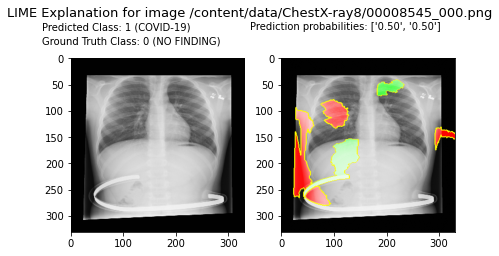

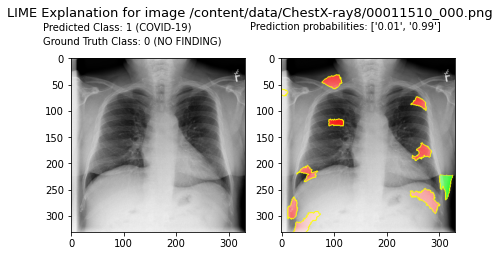

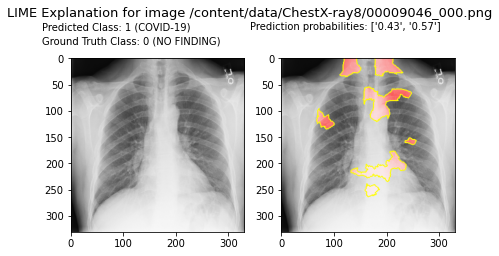

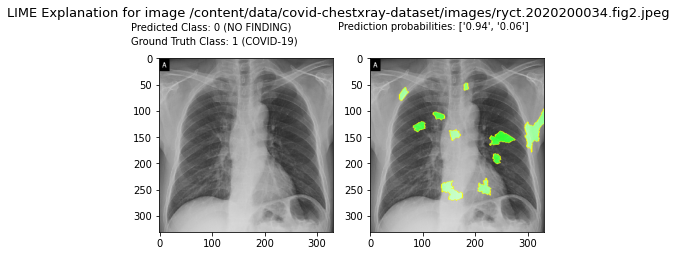

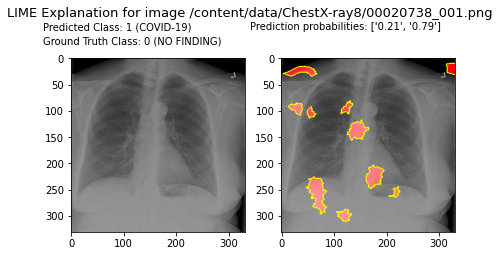

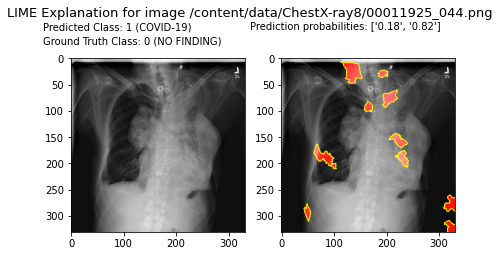

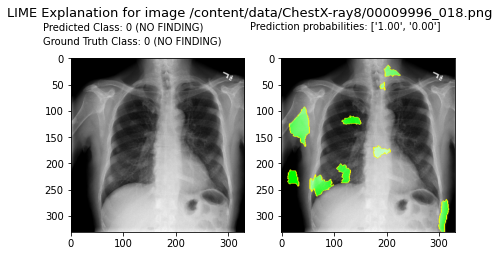

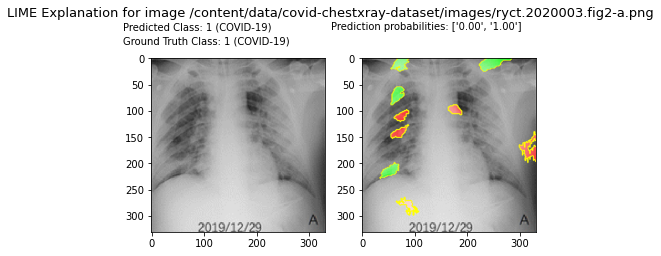

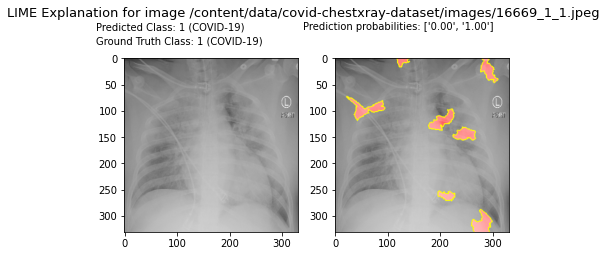

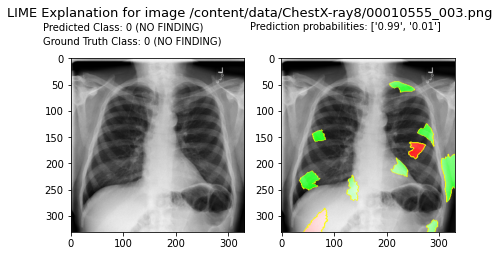

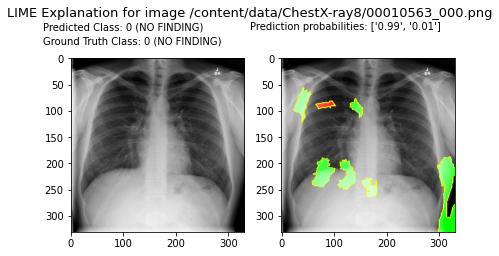

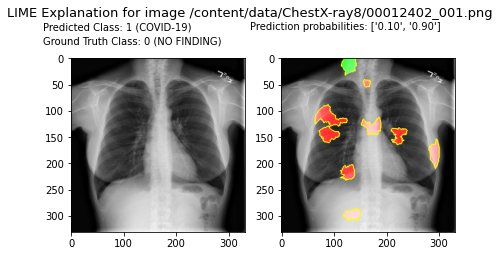

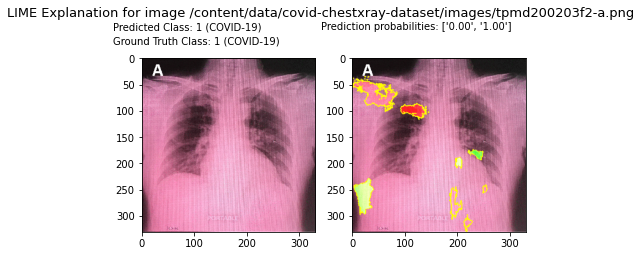

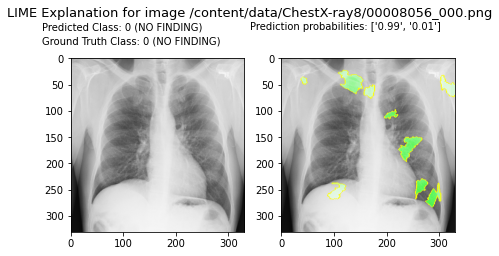

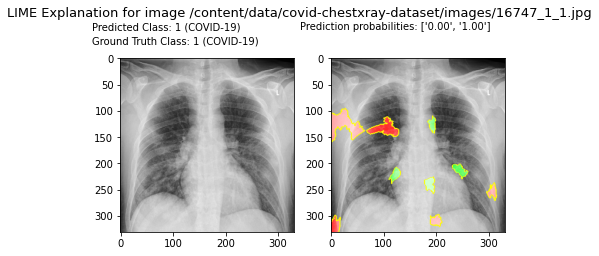

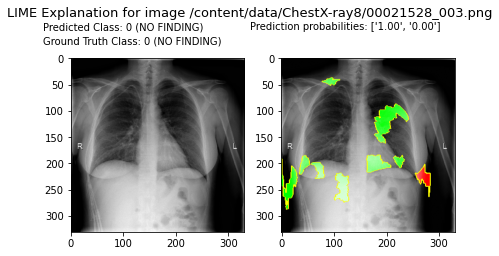

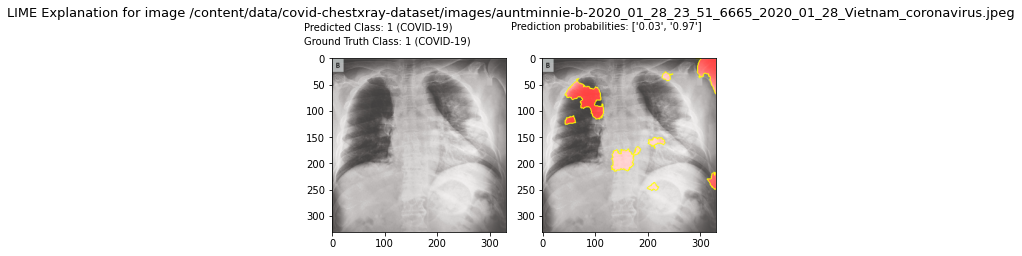

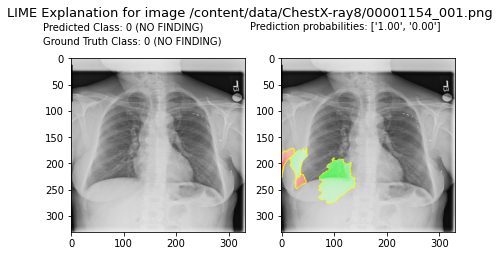

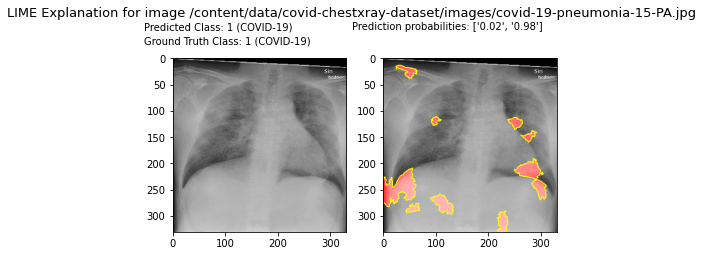

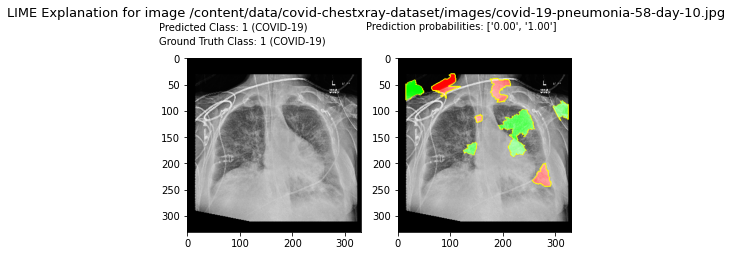

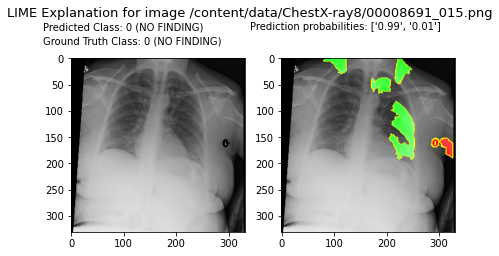

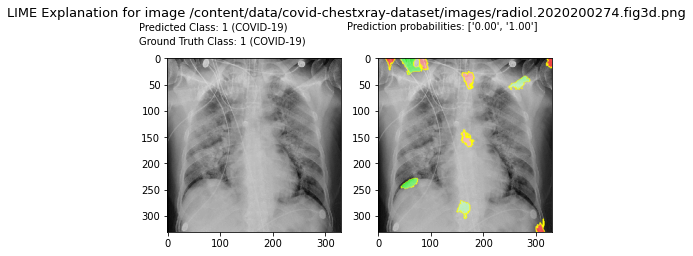

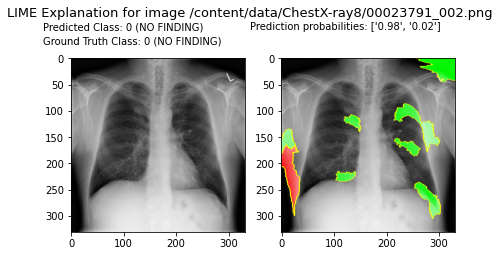

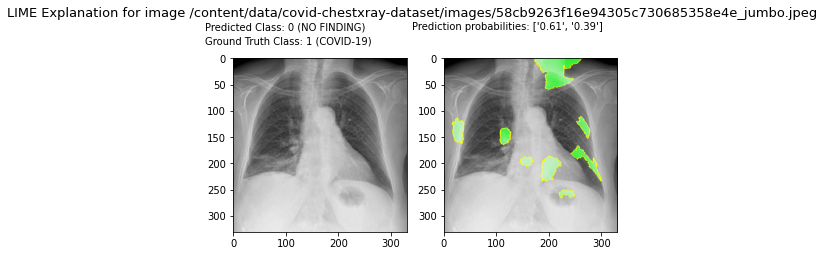

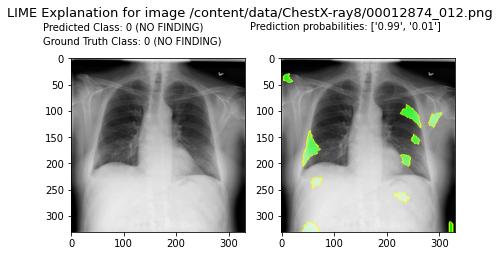

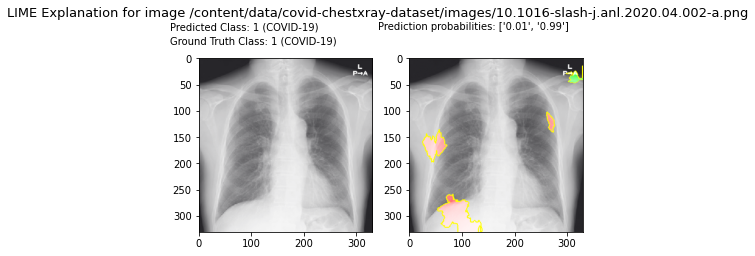

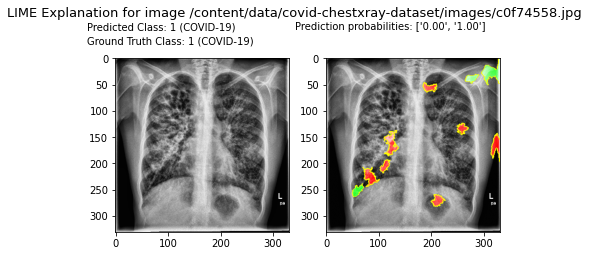

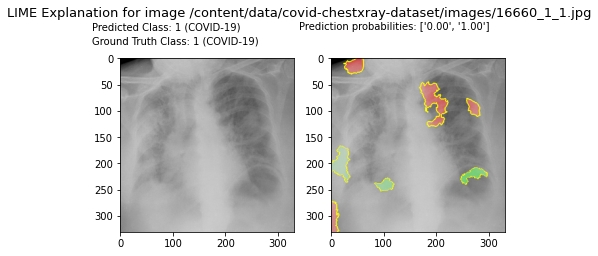

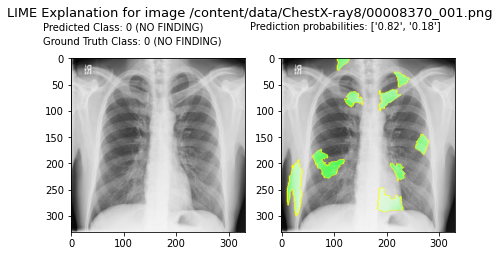

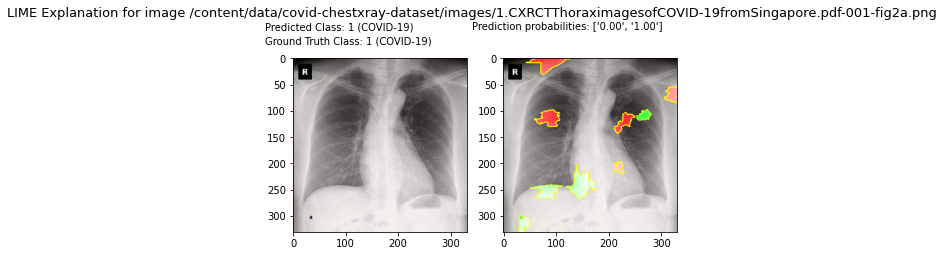

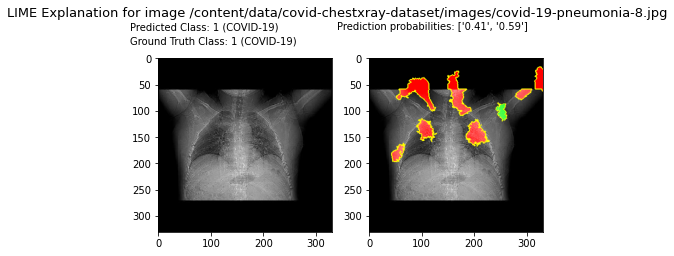

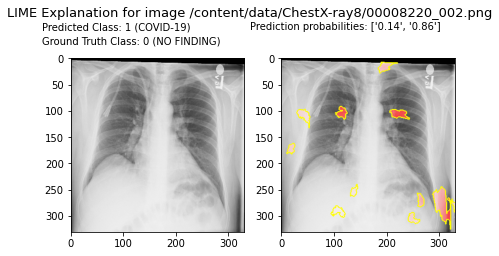

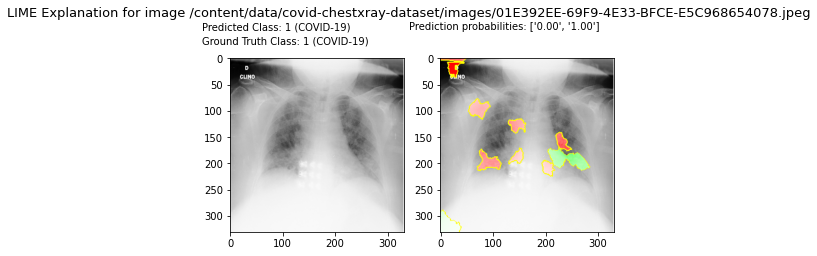

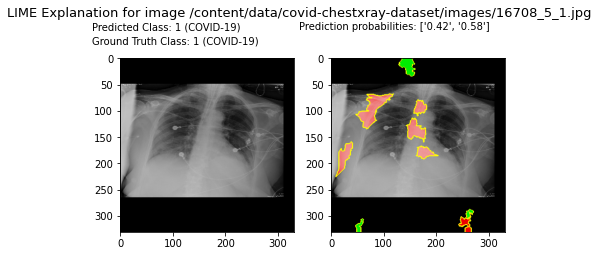

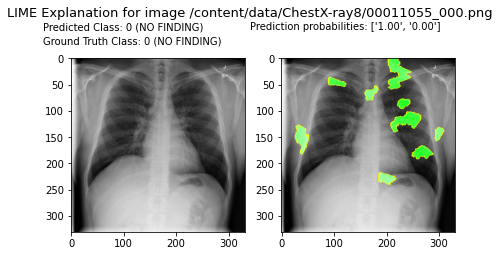

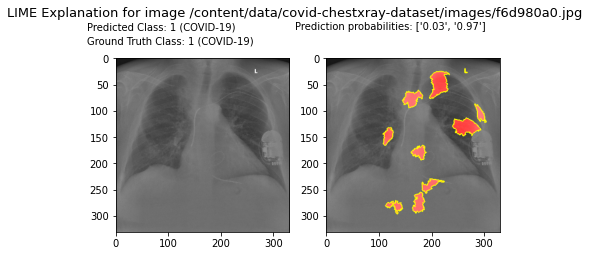

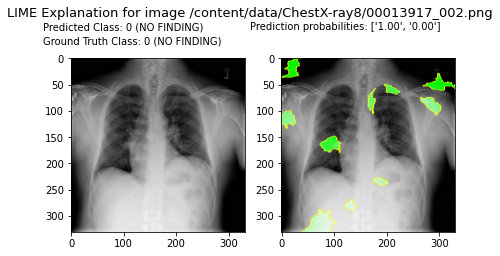

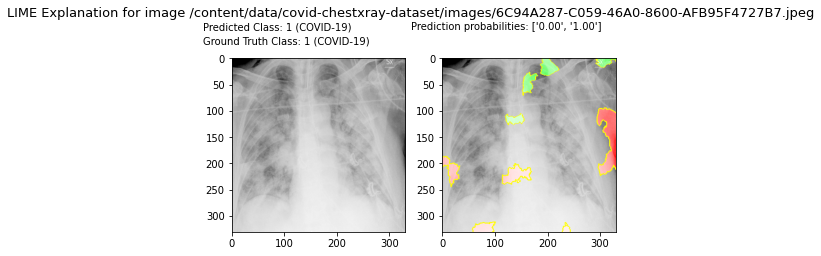

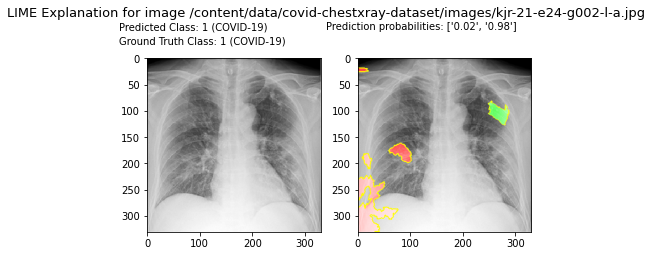

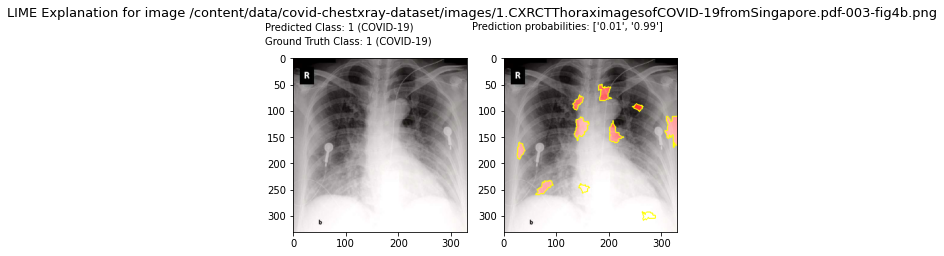

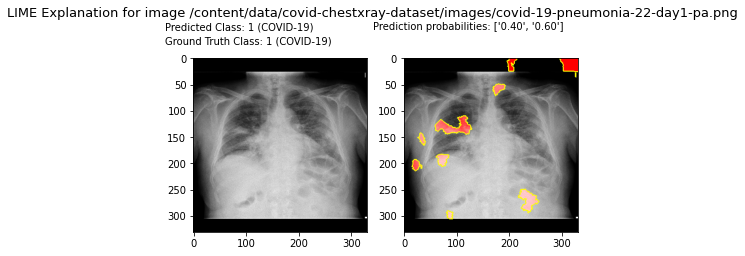

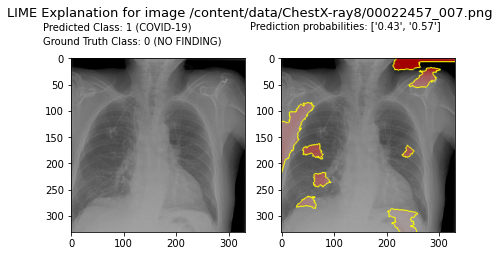

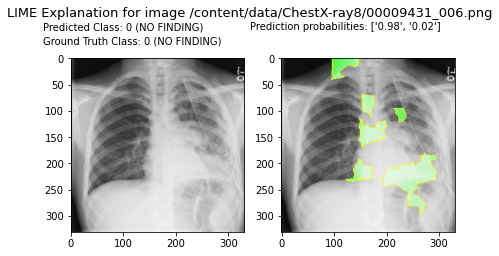

In [ ]:
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
from skimage.segmentation import mark_boundaries
from lime.lime_image import SegmentationAlgorithm

def visualize_explanation(orig_img, explanation, img_filename, label, probs, class_names, label_to_see='top', dir_path=None):

    # Plot original image on the left
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(orig_img)

    # Plot the image and its explanation on the right
    if label_to_see == 'top':
        label_to_see = explanation.top_labels[0]
    explanation.image = orig_img
    temp, mask = explanation.get_image_and_mask(label_to_see, positive_only=False, num_features=10, hide_rest=False)
    ax[1].imshow(mark_boundaries(temp, mask))

    # Display some information about the example
    pred_class = np.argmax(probs)
    fig.text(0.5, 0.9, "Prediction probabilities: " + str(['{:.2f}'.format(probs[i]) for i in range(len(probs))]),
             fontsize=10)
    fig.text(0.02, 0.9, "Predicted Class: " + str(pred_class) + ' (' + class_names[int(pred_class)] + ')', fontsize=10)
    if label is not None:
        fig.text(0.02, 0.85, "Ground Truth Class: " + str(class_names.index(label)) + ' (' + label + ')', fontsize=10)
    fig.suptitle("LIME Explanation for image " + img_filename, fontsize=13)
    fig.tight_layout()

    # Save the image
    filename = None
    if dir_path is not None:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        filename = os.path.join(dir_path, img_filename.split('/')[-1] + '_exp_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '.svg')
        plt.savefig(filename)
    return filename

lime_test_generator.reset()
for idx in range(NUM_TEST_IMG):
  x, _ = lime_test_generator.next()
  x = np.squeeze(x, axis=0)

  # Get the corresponding original image (no preprocessing)
  orig_img = cv2.imread(data['TEST']['filename'][idx])
  new_dim = (lime_dict['IMG_DIM'])
  orig_img = cv2.resize(orig_img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image

  # Make a prediction for this image and retrieve a LIME explanation for the prediction
  start_time = datetime.datetime.now()

  def predict(x):
      '''
      Helper function for LIME explainer. Runs model prediction on perturbations of the example.
      :param x: List of perturbed examples from an example
      :return: A numpy array constituting a list of class probabilities for each predicted perturbation
      '''
      y = lime_model.predict(x)  # Run prediction on the perturbations
      if y.shape[1] == 1:
          probs = np.concatenate([1.0 - y, y], axis=1)  # Compute class probabilities from the output of the model
      else:
          probs = y
      return probs

  # Algorithm for superpixel segmentation. Parameters set to limit size of superpixels and promote border smoothness
  segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=2.25, max_dist=50, ratio=0.1, sigma=0.15)
  # Generate explanation for the example
  explanation = lime_explainer.explain_instance(x.astype(np.double), predict, num_features=lime_dict['NUM_FEATURES'], num_samples=lime_dict['NUM_SAMPLES'], segmentation_fn=segmentation_fn)
  probs = predict(np.expand_dims(x, axis=0))

  print("Explanation time = " + str((datetime.datetime.now() - start_time).total_seconds()) + " seconds")

  # Get image filename and label
  img_filename = data['TEST']['filename'][idx]
  label = data['TEST']['label'][idx]

  # Rearrange prediction probability vector to reflect original ordering of classes in project config
  probs = [probs[0][lime_dict['CLASSES'].index(c)] for c in lime_test_generator.class_indices]

  # Visualize the LIME explanation and optionally save it to disk
  file_path = lime_dict['IMG_PATH']
  explanation_filenames = []
  if lime_dict['COVID_ONLY'] == True:
      label_to_see = lime_test_generator.class_indices['COVID-19']
  else:
      label_to_see = 'top'
  expalanation_filename = visualize_explanation(orig_img, explanation, img_filename, label, probs, lime_dict['CLASSES'], label_to_see=label_to_see,
                        dir_path=file_path)
  explanation_filenames.append(expalanation_filename)